# Курсовая работа

---
## по теме: "Построение рекомендательной системы в области закупок с помощью графовых нейронных сетей"

Выполнила: студентка учебной группы\
ПМ21-1\
Стаханова Анастасия Андреевна


# Введение

# 1. Импорт библиотек

In [4]:
#!pip install pymorphy2

In [5]:
#!pip install dgl

In [421]:
import pandas as pd
import numpy as np
import random
import re
import string
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from numba import jit

import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import scipy.sparse as sp
import itertools

import dgl
import dgl.function as fn
from dgl.nn import SAGEConv, GraphConv, GATConv

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Загрузка датасета

In [7]:
df = pd.read_excel('/content/ContractSearch(1-5000)_06.05.2024 (4).xlsx')
df.head()

,Номер реестровой записи контракта,Заказчик: наименование,Заказчик: ИНН,Предмет контракта,"Объект закупки: наименование товаров, работ, услуг",Цена контракта,Объект закупки: код позиции,"Объект закупки: сумма, рублей","Информация о поставщиках (исполнителях, подрядчиках) по контракту: наименование юридического лица (ф.и.о. физического лица)","Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН"
0,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000004,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
1,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Хлеб недлительного хранения,"'252 032,14'",10.71.11.110-00000002,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
2,'3183504891023000030',МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,'1835048910','№ 32787 Хлебобулочные изделия для нужд учрежд...,Булочные изделия,"'252 032,14'",10.71.11.120-00000004,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",'5920034144'
3,'2781020117024000019',САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,'7810201170',"'Оказание услуг на отпуск питьевой воды, прием...",Вода питьевая,"'100 740,00'",36.00.11.000,'100740.00',"ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ""ВОДОКАН...",'7830000426'
4,'2502700146623000079',ГОСУДАРСТВЕННОЕ КАЗЁННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРА...,'5027001466','Поставка продуктов питания : Поставка хлеба д...,Хлеб ржаной,"'179 550,00'",10.86.10.700,'45600.00',"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ЕГОРЬЕВСКИЙ ХЛЕБОКОМБИНАТ""",'5011017573'


В данном датасете имеются:\
1) Номер контракта (ID) - contract_number\
2) Наименование заказчика - customer_name\
3) ИНН заказчика (который мы будем использовать в качестве ID) - customer_INN\
4) Предмет конракта - contract_predmet\
5) Объекты закупки - contract_elems\
6) Сумма всего контракта (в один конракт могут входить несколько позиций или же несколько закупок) - contract_price\
7) Специальный код закупки - order_code\
8) Сумма закупки - order_price\
9) Наименование поставщика - provider_name\
10) ИНН поставщика (который мы будем использовать в качестве ID) - provider_INN

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29832 entries, 0 to 29831
Data columns (total 10 columns):
 #   Column                                                                                                                       Non-Null Count  Dtype 
---  ------                                                                                                                       --------------  ----- 
 0   Номер реестровой записи контракта                                                                                            29832 non-null  object
 1   Заказчик: наименование                                                                                                       29832 non-null  object
 2   Заказчик: ИНН                                                                                                                29832 non-null  object
 3   Предмет контракта                                                                                                        

In [9]:
print('Длина датасета = ', len(df))
print('Количество столбцов = ', len(df.columns))

Длина датасета =  29832
Количество столбцов =  10


Изменение наименований столбцов для удобства

In [10]:
new_names = ['contract_number','customer_name','customer_INN',
             'contract_predmet','contract_elems','contract_price',
             'order_code','order_price','provider_name','provider_INN']
df.columns = new_names

In [11]:
print('Количество пропущенных значений:')
df.isnull().sum()

Количество пропущенных значений:


contract_number      0
customer_name        0
customer_INN         0
contract_predmet    18
contract_elems       0
contract_price       0
order_code           0
order_price          3
provider_name        0
provider_INN         0
dtype: int64

# 3. Преобразования датасета

## 3.1 Работа с типами данных

Функция для преобразования ИНН в число

In [12]:
def work_with_INN(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').apply(lambda x: int(x))
work_with_INN(df, 'customer_INN')
work_with_INN(df, 'provider_INN')

Функция для корректного отображения цены контракта

In [13]:
def convert_price(df, column_name):
    df[column_name] = df[column_name].astype(str).str.replace("'", '').str.replace(",", ".").str.replace(" ", "").apply(lambda x: float(x))
convert_price(df, 'contract_price')

Функция для корректного отображения цены закупки. Также если значение order_price пустое, а contract_price содержит в себе какую-то цену, то функция добавляет информацию о ней в пустующую ячейку в солбец order_price

In [14]:
def process_column(df, column_name, default_column_name):
    for index, value in df[column_name].items():
        if isinstance(value, str):
            value = value.replace("'", "").replace(" ", "").replace(",", ".")
            value = float(value)
            if value == '':
                df.loc[index, column_name] = float(df.loc[index, default_column_name])
            else:
                df.loc[index, column_name] = float(value)
    df[column_name] = df[column_name].apply(lambda x: float(x))
process_column(df, 'order_price', 'contract_price')

## 3.2 Изменение содержания данных

Создание нового столбца 'product', в который войдут contract_elems и contract_predmet

In [15]:
df['product'] = df['contract_elems'] + ' ' + df['contract_predmet']
df = df.drop(['contract_elems', 'contract_predmet'], axis =1)

Убираем колонку 'contract_price', так как она содержит в себе информацию о цене всего контракта, а не конкретно одной закупки

In [16]:
df = df.drop(['contract_price'], axis = 1)

## 3.3 Удаление пропусков и дубликатов

In [17]:
df = df.dropna()
df = df.drop_duplicates()
len(df)

28471

Теперь нам не понадбится колонка 'order_code', так как именно она помогла отследить и удалить дубликаты (ИНН и order_code давали уникальное значение для каждого контракта)

In [18]:
df = df.drop(['order_code'], axis = 1)

## 3.4 Создание уникального кода закупки

Удаленный 'order_code' - это уникальный номер всего контракта, поэтому в некоторых строках он одинаковый, так как в контракте могут быть несколько объектов (закупок). Но нам нужно добиться уникального номера именно для каждой закупки. Поэтому создадим новую колонку с уникальным кодом (ID) для удобства дальнейшей работы.

In [19]:
def add_ID(df):
    random_values = [''.join(random.choices(string.digits, k=15)) for _ in range(len(df))]
    new_column_name = 'ID'
    df[new_column_name] = random_values
    return df

df = add_ID(df)
df = df[['ID'] + [x for x in df.columns if x != 'ID']]
df = df.drop(['contract_number'], axis = 1)
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,596156707716022,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,640491379185595,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,044771723159733,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [20]:
df['ID'] = df['ID'].apply(lambda x: int(x))

## 3.5 Итоги обработки

In [21]:
df.head(3)

,ID,customer_name,customer_INN,order_price,provider_name,provider_INN,product
0,596156707716022,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.01,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
1,640491379185595,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.02,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Хлеб недлительного хранения '№ 32787 Хлебобуло...
2,44771723159733,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛ...,1835048910,84010.03,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАРА...",5920034144,Булочные изделия '№ 32787 Хлебобулочные издели...


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28471 entries, 0 to 29831
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             28471 non-null  int64  
 1   customer_name  28471 non-null  object 
 2   customer_INN   28471 non-null  int64  
 3   order_price    28471 non-null  float64
 4   provider_name  28471 non-null  object 
 5   provider_INN   28471 non-null  int64  
 6   product        28471 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.7+ MB


В итоговом датасете имеются:\
1) Номер закупки - ID\
2) Наименование заказчика - customer_name\
3) ИНН заказчика - customer_INN\
4) Сумма закупки - order_price\
5) Наименование поставщика - provider_name\
6) ИНН поставщика - provider_INN\
7) Содержание закупки (товар/услуга) - product

In [23]:
df.to_csv('all_data.csv', index = False)

# 4. Разделение датасета

## 4.1 Ребра графа (edges)

In [25]:
df = pd.read_csv('/content/all_data.csv')

In [27]:
edges = df[['ID', 'customer_INN', 'provider_INN', 'order_price']]
edges.head(5)

,ID,customer_INN,provider_INN,order_price
0,684649047945804,1835048910,5920034144,84010.01
1,104190655198283,1835048910,5920034144,84010.02
2,676289714254967,1835048910,5920034144,84010.03
3,772420183161960,7810201170,7830000426,100740.00
4,747513979813057,5027001466,5011017573,45600.00


In [28]:
print('Длина датасета = ', len(edges))
print('Количество колонок = ', len(edges.columns))

Длина датасета =  28471
Количество колонок =  4


## 4.2 Вершины графа (nodes)

In [29]:
nod = pd.concat([df['customer_INN'], df['provider_INN']]).unique()
len(nod)

3888

In [30]:
print('Кол-во уникальных ИНН поставщиков -', len(df['provider_INN'].unique()))

Кол-во уникальных ИНН поставщиков - 2026


In [31]:
print('Кол-во уникальных ИНН заказщиков -', len(df['customer_INN'].unique()))

Кол-во уникальных ИНН заказщиков - 1862


Функция, которая выписывает все уникальные ИНН как заказчиков, так и поставщиков и ищет для них всю информацию о продуктав, с которыми они встречались

In [32]:
def extract_product_info(df, nodes):
    unique_prov = list(df['provider_INN'].unique())
    products_info = []
    for node in nodes:
      if node in unique_prov:
        supplier_data = df[df['provider_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)

        products_info.append({'INN': node, 'product': product_info})
      else:
        supplier_data = df[df['customer_INN'] == node]

        product_info_list = list(supplier_data['product'].astype(str).unique())
        product_info = ', '.join(product_info_list)
        products_info.append({'INN': node, 'product': product_info})

    new_dataset = pd.DataFrame(products_info)
    new_dataset = new_dataset.sort_values(by='INN').reset_index(drop=True)

    return new_dataset
nodes = extract_product_info(df, nod)
nodes

,INN,product
0,104008357,Филе тресковых рыб мороженое (Филе минтая) 'П...
1,104008396,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
2,105003182,"Молоко, 2,5%, 1 л 'Поставка продуктов питания..."
3,105013462,Смесь сушеных фруктов (сухой компот) 'Сухофрук...
4,105019055,Молоко питьевое 'продукты питания (молоко пить...
...,...,...
3883,862199205474,Выполнение работ по текущему ремонту 5-ой груп...
3884,910209932045,Говядина замороженная для детского питания. От...
3885,920100129510,Мясо сельскохозяйственной птицы охлажденное дл...
3886,920355485507,Филе лососевых рыб мороженое. отсутствует 'на ...


In [34]:
print('Длина датасета = ', len(nodes))
print('Количество колонок = ', len(nodes.columns))

Длина датасета =  3888
Количество колонок =  2


## 5. Лемматизация информации и продуктах

In [36]:
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

In [37]:
@jit
def preprocess_text_numba(text):
    # Удаление всех символов, кроме букв
  text = re.sub(r'[^А-Яа-я]', ' ', text)
  words = text.lower().split()
    # Удаление стоп-слов
  filtered_words = [w for w in words if w not in stop_words]
    # Лемматизация
  lemmatized_words = [morph.parse(word)[0].normal_form for word in filtered_words]

  return ' '.join(lemmatized_words)

def preprocess_column_numba(df, column_name):
    tqdm.pandas()

    def preprocess_row(row):
        row[column_name] = preprocess_text_numba(row[column_name])
        return row

    updated_df = df.progress_apply(preprocess_row, axis=1)

    return updated_df

dff = preprocess_column_numba(nodes, 'product')
dff.head(3)

100%|██████████| 3888/3888 [02:31<00:00, 25.73it/s]


,INN,product
0,104008357,филе тресковый рыба мороженое филе минтай пост...
1,104008396,молоко л поставка продукт питание молочный про...
2,105003182,молоко л поставка продукт питание молочный про...


Эта функция обрабатывает строки в столбце следующим образом: если в строке менее 6 слов, то добавляются самые часто встречающиеся слова, чтобы длина строки стала равной 6; если слов больше или равно 6, то выбирается топ 6 самых встречающихся. В результате, в каждой строке будет содержаться 6 слов в виде строки.

In [41]:
def process_words_in_column(df, column_name):
    def fill_missing_words(words):
        count = Counter(words)
        while len(words) != 6:
            most_common_word = count.most_common(1)[0][0]
            words.append(most_common_word)
        return ' '.join(words)

    def get_top_words(words):
        count = Counter(words)
        top_words = [word for word, _ in count.most_common(6)]
        return ' '.join(top_words)

    def process_row(row):
        if isinstance(row[column_name], str):
            words = row[column_name].split()
        elif isinstance(row[column_name], list):
            words = row[column_name]
        else:
            words = []

        if len(words) == 0:
          return ''
        elif len(words) > 6:
            return get_top_words(words)
        else:
            return fill_missing_words(words)

    df[column_name] = df.apply(process_row, axis=1)

    return df

In [42]:
processed_df = process_words_in_column(dff, 'product')
processed_df

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба
1,104008396,поставка продукт питание молочный продукция гр
2,105003182,продукт питание поставка молочный продукция мо...
3,105013462,крупа изделие рис горох фасоль печение
4,105019055,молоко питьевой продукт питание молоко питьевой
...,...,...
3883,862199205474,сиверский выполнение работа текущий ремонт ой
3884,910209932045,говядина питание субпродукт заморозить отсутст...
3885,920100129510,куриный питание мясо сельскохозяйственный птиц...
3886,920355485507,рыба филе мороженое отсутствовать поставка про...


In [43]:
for i in processed_df['product']:
  if len(i.split()) < 6 and len(i.split())!=0:
    print(i)
    print('Где-то есть строка не той длины')

In [44]:
nodes_pro = processed_df
nodes_pro = nodes_pro.fillna('')

In [45]:
edges.to_csv('d_edges.csv', index = False)
nodes_pro.to_csv('d_nodes.csv', index = False)

# 6. Векторизация

Свойства графа не могут содержать данные в виде строкового формата, поэтому столбец 'product' должен быть векторизирован.
Для этого использован  TF-IDF (TF-IDF вычисляет числовые представления слов в тексте, учитывая частотность их употребления и уникальность в контексте документов. Используя TF-IDF, можно выделить ключевые слова и фразы, которые наиболее информативно описывают содержание текста
.
Полученные "объекты" векторизируются, так как в качестве свойств графа нельзя использовать данные формата str.
TF-IDF (Term Frequency — Inverse Dense Frequency) - это метод, который помогает определить важность слов в тексте на основе их частотности.

In [293]:
nodes = pd.read_csv('/content/d_nodes.csv')
nodes.head(1)

,INN,product
0,104008357,поставка продукт питание молочный продукция рыба


In [294]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(nodes['product'].values.astype('U').tolist())
nodes_info = torch.tensor(X.toarray())
nodes_info

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [295]:
nodes_info.shape

torch.Size([3888, 2286])

# 5. Создание графа

## 5.1 Подготовка вершин

In [708]:
edges = pd.read_csv('/content/d_edges.csv')
edges.head(1)

,ID,customer_INN,provider_INN,order_price
0,684649047945804,1835048910,5920034144,84010.01


In [709]:
all_inn = sorted(pd.concat([edges['customer_INN'], edges['provider_INN']]).unique().tolist())
counter = {val: i for i, val in enumerate(all_inn)}

In [710]:
customer_inn = [counter[i] for i in edges['customer_INN']]
provider_inn = [counter[i] for i in edges['provider_INN']]
nodes_dict = {'customer_INN':customer_inn,
              'provider_INN': provider_inn}

In [711]:
nodes = pd.DataFrame(nodes_dict)
nodes

,customer_INN,provider_INN
0,420,2024
1,420,2024
2,420,2024
3,3199,3347
4,1831,1819
...,...,...
28466,469,494
28467,563,557
28468,493,581
28469,593,528


## 5.2 Граф

In [712]:
g = dgl.graph((nodes['customer_INN'], nodes['provider_INN']))
g.ndata['products'] = nodes_info
g.edata['order_price'] = torch.tensor(edges['order_price'])

In [713]:
print('Кол-во вершин = ', g.num_nodes())
print('Кол-во рёбер = ', g.num_edges())

Кол-во вершин =  3888
Кол-во рёбер =  28471


In [359]:
g.edges() #Массив, содержащий ребра графа

(tensor([420, 420, 420,  ..., 493, 593, 470]),
 tensor([2024, 2024, 2024,  ...,  581,  528,  494]))

In [246]:
g.in_degrees() #Входящие степени узлов в графе

tensor([ 0,  0, 13,  ...,  3,  3,  1])

In [247]:
g.out_degrees() #Исходящие степени узлов в графе.

tensor([8, 5, 0,  ..., 0, 0, 0])

## 5.3 Визуализация графа

In [100]:
G = dgl.to_networkx(g)

In [112]:
colors_dict = {}
for i in G.nodes():
  if i in nodes['customer_INN'].tolist():
    colors_dict[i] = '#d4a5d9'
  else:
    colors_dict[i] = '#809e77'

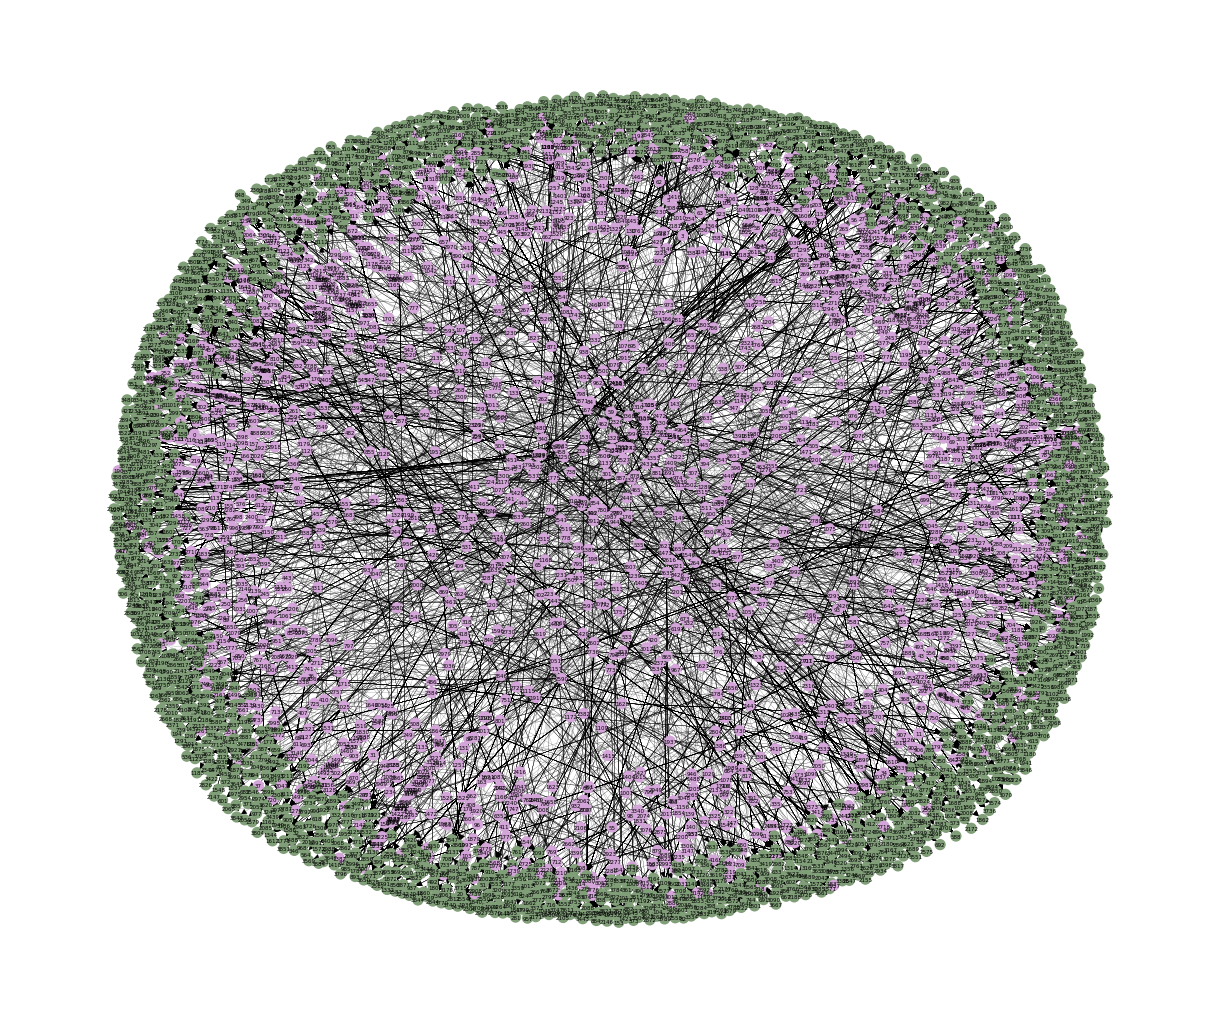

In [115]:
plt.figure(figsize=(12, 10))
nx.draw(G,
        with_labels=True,
        font_size=4,
        node_size=50,
        width=0.1,
        node_color = [colors_dict[node] for node in G.nodes()])
plt.show()

customer_INN - розовый цвет\
provider_INN - зеленый цвет

# 6. Разделение на тренировочную и тестовую выборки

In [714]:
def split_graph(g):
    cust, prov = g.edges()
    indices = np.arange(g.num_edges()) # Индексы вершин
    n_nod = g.num_nodes()
    random_indices = np.random.permutation(indices) #рандомный порядок вершин

    test_ratio = 0.1
    test_size = int(len(random_indices) * test_ratio)
    train_size = g.num_edges() - test_size
    print('test_size = ', test_size)
    print('train_size = ', train_size)

    test_pos_cust, test_pos_prov = cust[random_indices[:test_size]], prov[random_indices[:test_size]]
    train_pos_cust, train_pos_prov = cust[random_indices[test_size:]], prov[random_indices[test_size:]]

    # Разреженная матрица смежности (информация о позитивных ребрах)
    adj = sp.coo_matrix((np.ones(len(cust)), (cust.numpy(), prov.numpy())), shape=(n_nod, n_nod))
    # Информация об отсутствующих ребрах (негативных)
    adj_negative = 1 - adj.todense() - np.eye(n_nod)
    negative_cust, negative_prov = np.where(adj_negative != 0)

    negative_random_indices = np.random.choice(len(negative_cust), g.num_edges())
    test_negative_cust, test_negative_prov= negative_cust[negative_random_indices[:test_size]], negative_prov[negative_random_indices[:test_size]]
    train_negative_cust, train_negative_prov = negative_cust[negative_random_indices[test_size:]], negative_prov[negative_random_indices[test_size:]]

    train_g = dgl.remove_edges(g, random_indices[:test_size])
    train_pos_g = dgl.graph((train_pos_cust, train_pos_prov), num_nodes=n_nod)
    train_negative_g = dgl.graph((train_negative_cust, train_negative_prov), num_nodes=n_nod)
    test_pos_g = dgl.graph((test_pos_cust, test_pos_prov), num_nodes=n_nod)
    test_negative_g = dgl.graph((test_negative_cust, test_negative_prov), num_nodes=n_nod)

    return train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g

train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g = split_graph(g)

test_size =  2847
train_size =  25624


In [715]:
train_g, train_pos_g, train_negative_g, test_pos_g, test_negative_g

(Graph(num_nodes=3888, num_edges=25624,
       ndata_schemes={'products': Scheme(shape=(2286,), dtype=torch.float64)}
       edata_schemes={'order_price': Scheme(shape=(), dtype=torch.float64)}),
 Graph(num_nodes=3888, num_edges=25624,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3888, num_edges=25624,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3888, num_edges=2847,
       ndata_schemes={}
       edata_schemes={}),
 Graph(num_nodes=3888, num_edges=2847,
       ndata_schemes={}
       edata_schemes={}))

# 7. Используемые метрики

Функция потерь — это просто потеря двоичной перекрестной энтропии
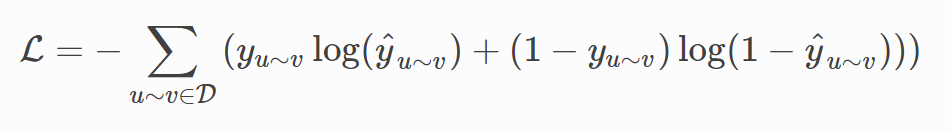

In [716]:
def compute_loss(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score])
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ])

    # Вычисляем бинарную перекрестную энтропию
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    return loss

In [717]:
def compute_auc(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).numpy()
    return roc_auc_score(labels, scores)

In [718]:
def compute_f1(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])]
    ).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return f1_score(labels, pred_labels)

In [719]:
def compute_accuracy(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return accuracy_score(labels, pred_labels)

In [720]:
def compute_conf_matrix(positive_score, negative_score):
    scores = torch.cat([positive_score, negative_score]).detach().numpy()
    labels = torch.cat([
        torch.ones(positive_score.shape[0]),
        torch.zeros(negative_score.shape[0])
    ]).detach().numpy()
    pred_labels = np.where(scores > 0.5, 1, 0)
    return confusion_matrix(labels, pred_labels)

# 8. Модели

## 8.1 GraphSAGE

In [743]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hid_feats):
        super(GraphSAGE, self).__init__()
        self.layer1 = SAGEConv(in_feats, hid_feats)
        self.layer2 = SAGEConv(hid_feats, hid_feats)

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.relu(h)
        h = self.layer2(g,h)
        return h

## 8.2 DotPredictor

In [738]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:,0]

## 8.3 MLPPredictor

In [739]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = (torch.cat([edges.src['h'], edges.dst['h']], 1)).to(torch.float32)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

## 8.4 GCN

In [740]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout):
        super(GCN, self).__init__()
        self.layer1 = GraphConv(in_feats, hid_feats, allow_zero_in_degree=True)
        self.batch_norm = nn.BatchNorm1d(hid_feats)
        self.dropout = nn.Dropout(dropout)
        self.layer2 = GraphConv(hid_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, g, features):
        h = self.layer1(g, features)
        h = F.leaky_relu(h)
        h = self.batch_norm(h)
        h = self.dropout(h)
        h = self.layer2(g, h)
        return h

# 9. Обучение моделей

In [751]:
acc, f, auc, time = [], [], [], []

## 9.1 GraphSAGE и DotPredictor

In [745]:
model = GraphSAGE(train_g.ndata["products"].shape[1], 8)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.01
)

In [746]:
%%time
loss_values, f1_values = [], []

for i in range(250):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    f1 = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))
    f1_values.append(f1)
    loss_values.append(loss.item())

    if i % 10 == 0:
        print("In epoch {}, loss: {}".format(i, round(loss.item(), 5)))

In epoch 0, loss: 0.69729
In epoch 10, loss: 0.61172
In epoch 20, loss: 0.49671
In epoch 30, loss: 0.46504
In epoch 40, loss: 0.43502
In epoch 50, loss: 0.409
In epoch 60, loss: 0.38876
In epoch 70, loss: 0.37097
In epoch 80, loss: 0.35441
In epoch 90, loss: 0.33827
In epoch 100, loss: 0.32172
In epoch 110, loss: 0.30572
In epoch 120, loss: 0.29077
In epoch 130, loss: 0.27693
In epoch 140, loss: 0.26413
In epoch 150, loss: 0.25207
In epoch 160, loss: 0.24057
In epoch 170, loss: 0.22933
In epoch 180, loss: 0.2183
In epoch 190, loss: 0.20798
In epoch 200, loss: 0.19854
In epoch 210, loss: 0.19017
In epoch 220, loss: 0.18244
In epoch 230, loss: 0.17528
In epoch 240, loss: 0.16865
CPU times: user 55.7 s, sys: 44.9 s, total: 1min 40s
Wall time: 1min 43s


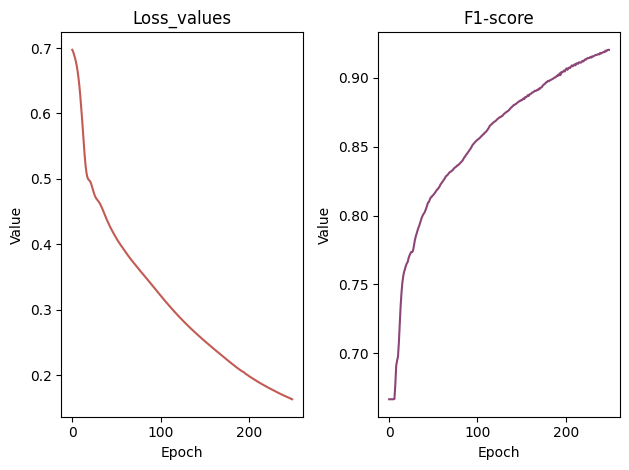

In [747]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [748]:
with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

In [752]:
def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 3)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 3)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 3)
  return accurary, f1, auc_
accurary, f1, auc_ = metrics()

acc.append(accurary)
f.append(f1)
auc.append(auc_)
time.append('1 min. 43')

print ('Accuracy = :', accurary)
print ('F1_score = :', f1)
print ('Auc = :', auc_)

Accuracy = : 0.803
F1_score = : 0.806
Auc = : 0.862


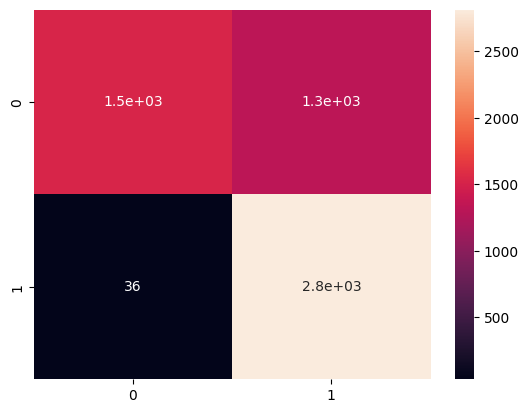

array([[1527, 1320],
       [  36, 2811]])

In [750]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

## 9.2 GraphSAGE и MLPPredictor

In [753]:
model = GraphSAGE(train_g.ndata["products"].shape[1], 16)
model = model.double()
predictor2 = MLPPredictor(16)
optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor2.parameters()), lr=0.01
)

In [754]:
%%time
loss_values, f1_values = [], []

for i in range(150):
    h2 = model(train_g, train_g.ndata["products"])
    positive_score = predictor2(train_pos_g, h2)
    negative_score = predictor2(train_negative_g, h2)
    loss = compute_loss(positive_score, negative_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    f1 = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))
    f1_values.append(f1)
    loss_values.append(loss.item())

    if i % 10 == 0:
        print("In epoch {}, loss: {}".format(i, round(loss.item(), 5)))

In epoch 0, loss: 0.69346
In epoch 10, loss: 0.51132
In epoch 20, loss: 0.19981
In epoch 30, loss: 0.15768
In epoch 40, loss: 0.14089
In epoch 50, loss: 0.13184
In epoch 60, loss: 0.12683
In epoch 70, loss: 0.12322
In epoch 80, loss: 0.11985
In epoch 90, loss: 0.11645
In epoch 100, loss: 0.1105
In epoch 110, loss: 0.10282
In epoch 120, loss: 0.09
In epoch 130, loss: 0.07166
In epoch 140, loss: 0.05382
CPU times: user 39.9 s, sys: 20.6 s, total: 1min
Wall time: 1min 1s


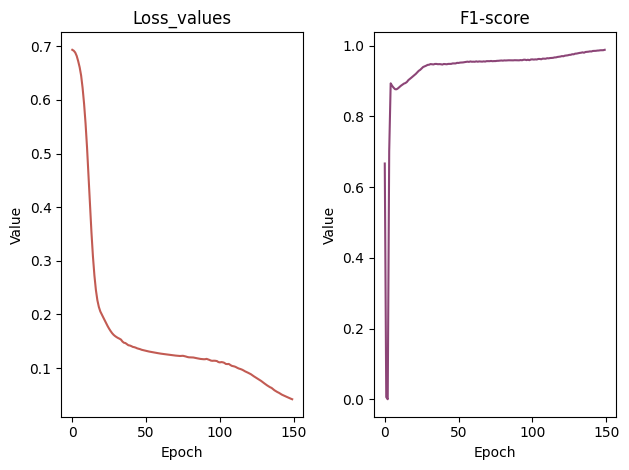

In [755]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [756]:
with torch.no_grad():
    positive_score_GM = predictor2(test_pos_g, h2)
    negative_score_GM = predictor2(test_negative_g, h2)
    positive_prob_GM = torch.sigmoid(positive_score_GM)
    negative_prob_GM = torch.sigmoid(negative_score_GM)

In [757]:
def metrics():
  accurary = round(compute_accuracy(positive_score_GM, negative_score_GM), 3)
  f1 = round(compute_f1(positive_prob_GM, negative_prob_GD), 3)
  auc_ = round(compute_auc(positive_score_GM, negative_score_GD), 3)
  return accurary, f1, auc_

accurary, f1, auc_ = metrics()

acc.append(accurary)
f.append(f1)
auc.append(auc_)
time.append('1 min. 1')

print ('Accuracy = :', accurary)
print ('F1_score = :', f1)
print ('Auc = :', auc_)

Accuracy = : 0.949
F1_score = : 0.794
Auc = : 0.818


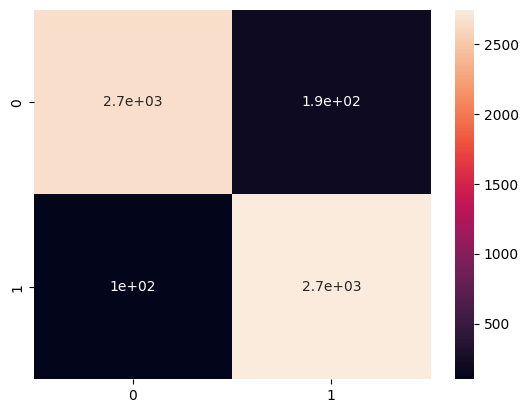

array([[2660,  187],
       [ 101, 2746]])

In [758]:
matrix = compute_conf_matrix(positive_prob_GM, negative_prob_GM)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

## 9.3 GCN и DotPredictor

In [759]:
model = GCN(train_g.ndata["products"].shape[1], 128, 4, 0.2)
model = model.double()
predictor1 = DotPredictor()
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), predictor1.parameters()), lr=0.001
)

In [760]:
%%time
loss_values, f1_values = [], []
for i in range(200):
    h1 = model(train_g, train_g.ndata["products"])
    positive_score = predictor1(train_pos_g, h1)
    negative_score = predictor1(train_negative_g, h1)
    loss = compute_loss(positive_score, negative_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    f1 = compute_f1(torch.sigmoid(positive_score), torch.sigmoid(negative_score))
    f1_values.append(f1)
    loss_values.append(loss.item())

    if i % 10 == 0:
        print("In epoch {}, loss: {}".format(i, round(loss.item(), 5)))

In epoch 0, loss: 0.80729
In epoch 10, loss: 0.75303
In epoch 20, loss: 0.72983
In epoch 30, loss: 0.71791
In epoch 40, loss: 0.71129
In epoch 50, loss: 0.7065
In epoch 60, loss: 0.70349
In epoch 70, loss: 0.70124
In epoch 80, loss: 0.69981
In epoch 90, loss: 0.69879
In epoch 100, loss: 0.69755
In epoch 110, loss: 0.69699
In epoch 120, loss: 0.69611
In epoch 130, loss: 0.69547
In epoch 140, loss: 0.6955
In epoch 150, loss: 0.69503
In epoch 160, loss: 0.69468
In epoch 170, loss: 0.69448
In epoch 180, loss: 0.69461
In epoch 190, loss: 0.69432
CPU times: user 51.3 s, sys: 2.79 s, total: 54.1 s
Wall time: 56.6 s


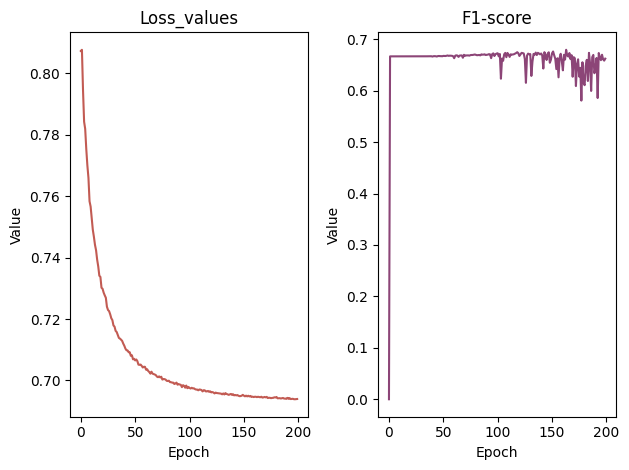

In [761]:
plt.subplot(1, 2, 1)
plt.plot(loss_values, color='#c25b53')
plt.title('Loss_values')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(f1_values, color='#8c4577')
plt.title('F1-score')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [762]:
with torch.no_grad():
    positive_score_GD = predictor1(test_pos_g, h1)
    negative_score_GD = predictor1(test_negative_g, h1)
    positive_prob_GD = torch.sigmoid(positive_score_GD)
    negative_prob_GD = torch.sigmoid(negative_score_GD)

In [763]:
def metrics():
  accurary = round(compute_accuracy(positive_score_GD, negative_score_GD), 3)
  f1 = round(compute_f1(positive_prob_GD, negative_prob_GD), 3)
  auc_ = round(compute_auc(positive_score_GD, negative_score_GD), 3)
  return accurary, f1, auc_
accurary, f1, auc_ = metrics()

acc.append(accurary)
f.append(f1)
auc.append(auc_)
time.append('56.6')

print ('Accuracy = :', accurary)
print ('F1_score = :', f1)
print ('Auc = :', auc_)

Accuracy = : 0.5
F1_score = : 0.667
Auc = : 0.632


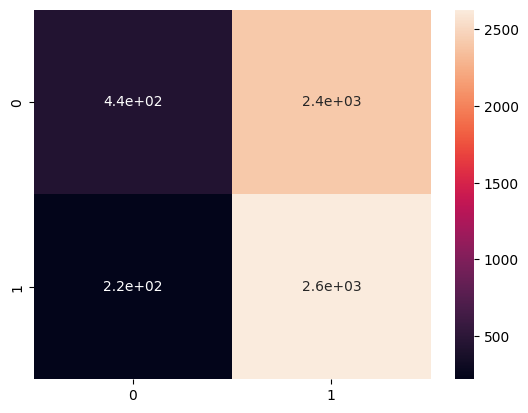

array([[ 442, 2405],
       [ 218, 2629]])

In [764]:
matrix = compute_conf_matrix(positive_prob_GD, negative_prob_GD)
sns.heatmap(matrix, annot=True)
plt.show()
matrix

## 9.4 Результаты

In [768]:
res_d = {'accurary': acc, 'f1-score': f, 'AUC': auc, 'time': time}
res_df = pd.DataFrame(res_d)
res_df.sort_values('f1-score', ascending=False)

,accurary,f1-score,AUC,time
0,0.803,0.806,0.862,1 min. 43
1,0.949,0.794,0.818,1 min. 1
2,0.500,0.667,0.632,56.6


# 10. Рекомендации

In [769]:
df = pd.read_csv('all_data (1).csv')

In [770]:
def get_contractor_name(df, inn):

    # Найти строку с соответствующим ИНН
    contractor_row = df[df['customer_INN'] == inn]

    if contractor_row.empty:
        return "Контрагент с таким ИНН не найден"
    else:
        contractor_name = contractor_row['customer_name'].values[0]
        return contractor_name

inn = 1835048910
contractor_name = get_contractor_name(df, inn)
print(contractor_name)

МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ДОШКОЛЬНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ "ДЕТСКИЙ САД №95"


In [162]:
nodes

,customer_INN,provider_INN
0,420,2024
1,420,2024
2,420,2024
3,3199,3347
4,1831,1819
...,...,...
28466,469,494
28467,563,557
28468,493,581
28469,593,528


In [777]:
d_nodes = pd.read_csv('/content/d_nodes.csv')

In [779]:
selected_node = np.random.randint(0, g.nodes().shape[0])
f'Вершина случайно выбранной компании: {selected_node}'

'Вершина случайно выбранной компании: 2101'

In [780]:
cust_node = sorted(nodes['customer_INN'].unique())
prov_node = sorted(nodes['provider_INN'].unique())

In [781]:
if selected_node in cust_node:
  print('Это заказчик')
elif selected_node in prov_node:
  print('Это поставщик')
else:
  print('Ничего не найдено')

Это поставщик
